# Assignment

In [1]:
import dotenv

dotenv.load_dotenv()

True

In [2]:
import os
import warnings

warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
import logging

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

from tensorflow.keras import utils, datasets, layers, models
from tensorflow.keras.applications.vgg16 import VGG16
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt

import pathlib
import random
import time
import csv
import math
from tqdm import tqdm
import itertools
from collections import defaultdict

In [3]:
# gpus = tf.config.experimental.list_physical_devices("GPU")
# if gpus:
#     try:
#         # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         tf.config.experimental.set_visible_devices(gpus[1], "GPU")
#         logical_gpus = tf.config.experimental.list_logical_devices("GPU")
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Memory growth must be set before GPUs have been initialized
#         print(e)

In [4]:
import urllib.request

if not os.path.exists("lab11_1_lib.py"):
    urllib.request.urlretrieve(
        "https://nthu-datalab.github.io/ml/labs/11-1_CNN/lab11_1_lib.py",
        "lab11_1_lib.py",
    )

from lab11_1_lib import draw_timeline

# Start

In [5]:
# You need to download the prepared data and unzip the file in current path('./')
data_root = pathlib.Path("./oregon_wildlife")

# print the subfolders.
print("classes:")
for item in data_root.iterdir():
    print(item)

all_image_paths = list(data_root.glob("*/*"))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [
    path for path in all_image_paths if path[-3:] not in ("gif", "bmp")
]
image_count = len(all_image_paths)
print("\ntotal img num:", image_count)

classes:
oregon_wildlife/nutria
oregon_wildlife/raccoon
oregon_wildlife/cougar
oregon_wildlife/bald_eagle
oregon_wildlife/black_bear
oregon_wildlife/virginia_opossum
oregon_wildlife/deer
oregon_wildlife/raven
oregon_wildlife/sea_lions
oregon_wildlife/red_fox

total img num: 7168


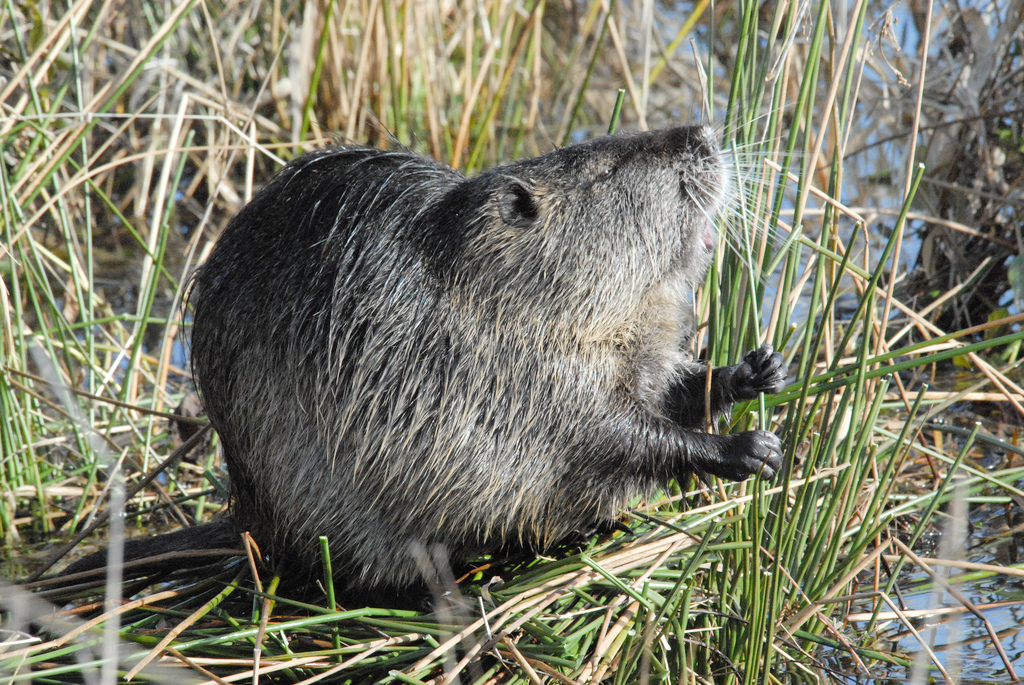

nutria


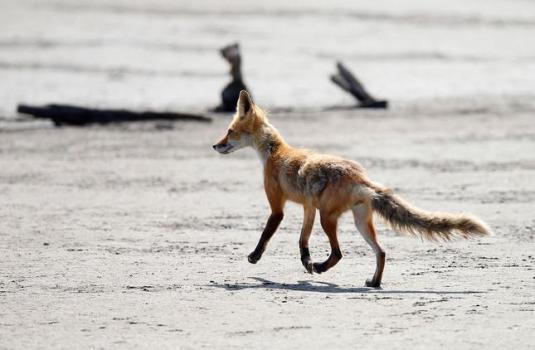

red_fox


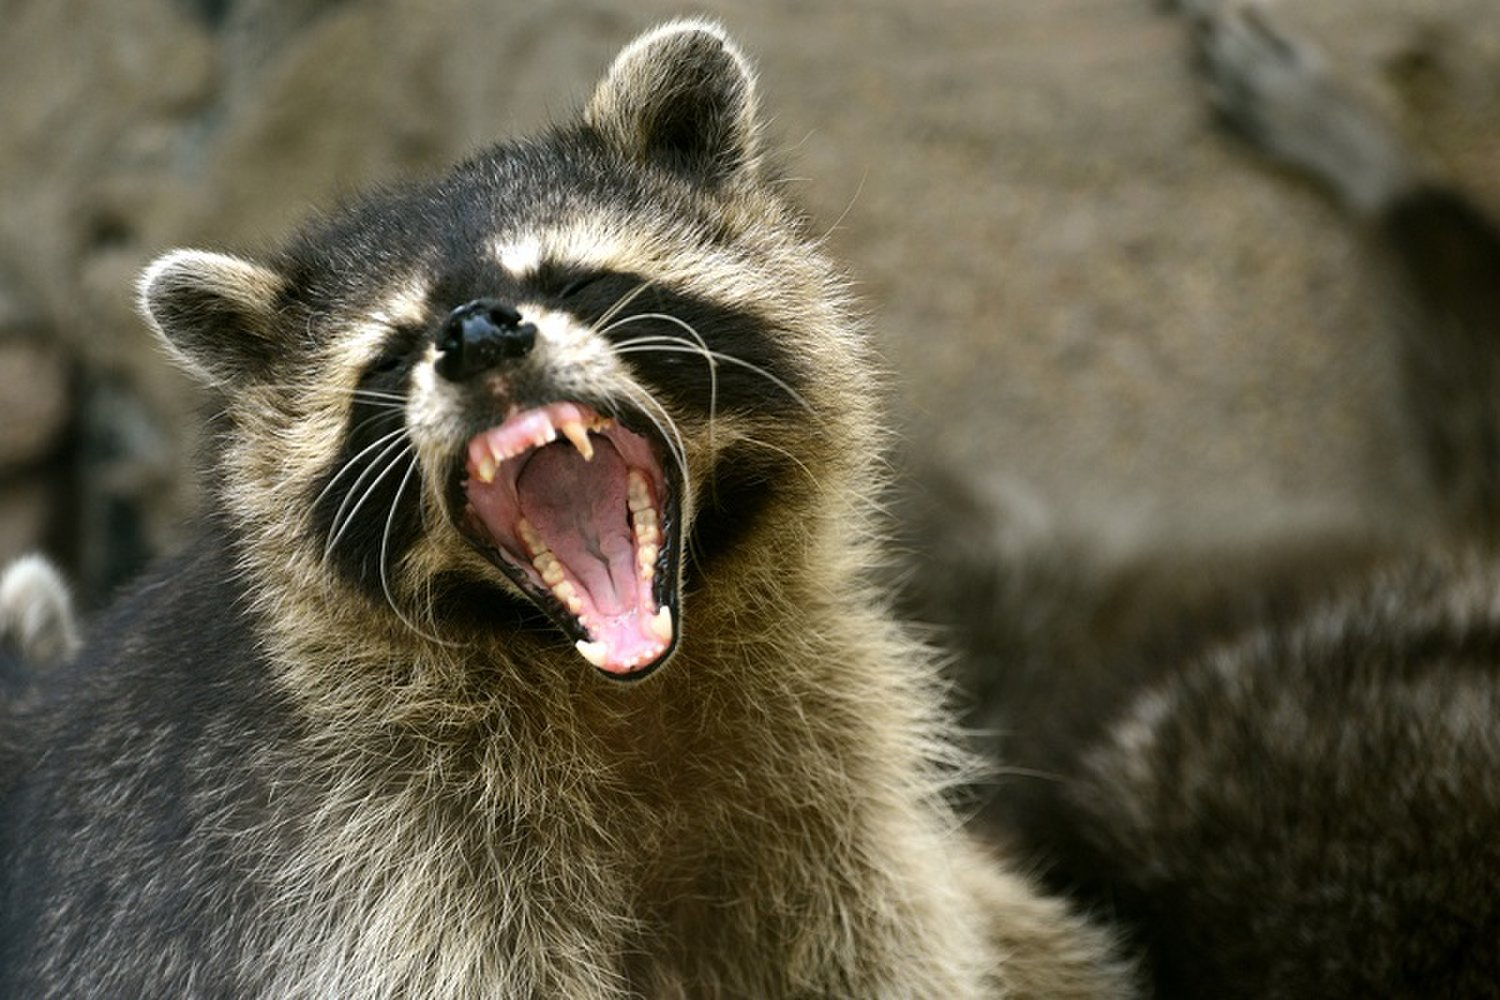

raccoon


In [6]:
# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split("/")[-2])

In [7]:
# get the label
label_names = sorted(
    item.name for item in data_root.glob("*/") if item.is_dir()
)
# total label
n_classes = len(label_names)
print(label_names)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [8]:
# get the mapping dict
label_to_index = dict((name, index) for index, name in enumerate(label_names))
index_to_label = dict((index, name) for index, name in enumerate(label_names))
print(label_to_index)

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


In [9]:
# get the label data
all_image_label = [
    label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths
]
print("First 10 label indices: ", all_image_label[:10])

First 10 label indices:  [8, 9, 2, 9, 5, 2, 5, 4, 5, 4]


In [10]:
# Create training and testing sets using an 80-20 split
img_path_train, img_path_test, label_train, label_test = train_test_split(
    all_image_paths, all_image_label, test_size=0.2, random_state=0
)
print("training data: %d" % (len(img_path_train)))
print("testing data: %d" % (len(img_path_test)))

training data: 5734
testing data: 1434


In [11]:
# save (img_path, label) pairs
with open("train.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["img_path", "label"])
    for img_path, label in zip(img_path_train, label_train):
        writer.writerow([img_path, label])

with open("test.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["img_path", "label"])
    for img_path, label in zip(img_path_test, label_test):
        writer.writerow([img_path, label])

In [12]:
# Feel free to change IMAGE_SIZE_CROPPED if using random_crop in your data augmentation process, but make sure the input resize back to (300,300,3) before feed into VGG16
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3

In [13]:
# construct a new dataset with time informantion
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters, img, label)
    OUTPUT_SIGNATURE = (
        tf.TensorSpec(
            shape=(2, 1), dtype=tf.string
        ),  # steps: [("Open",), ("Read",)]
        tf.TensorSpec(
            shape=(2, 2), dtype=tf.float32
        ),  # timings: [(open_enter, open_elapsed), (read_enter, read_elapsed)]
        tf.TensorSpec(
            shape=(2, 3), dtype=tf.int32
        ),  # counters: [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, example_idx)]
        tf.TensorSpec(shape=(300, 300, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32),  # label
    )

    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(
        itertools.count
    )  # Number of epochs done for each dataset

    def _generator(instance_idx, filename, open_file, read_file):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        open_enter = time.perf_counter()
        img_paths, label = open_file(filename)
        open_elapsed = time.perf_counter() - open_enter
        # ----------------

        # Reading the file
        for sample_idx in range(len(img_paths)):
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            img = read_file(img_paths[sample_idx])
            read_elapsed = time.perf_counter() - read_enter

            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [
                    (instance_idx, epoch_idx, -1),
                    (instance_idx, epoch_idx, sample_idx),
                ],
                img,
                label[sample_idx],
            )
            open_enter, open_elapsed = (
                -1.0,
                -1.0,
            )  # Negative values will be filtered

    def __new__(cls, filename, open_file, read_file):
        def generator_func(instance_idx, filename):
            return cls._generator(instance_idx, filename, open_file, read_file)

        return tf.data.Dataset.from_generator(
            generator_func,
            output_signature=cls.OUTPUT_SIGNATURE,
            args=(next(cls._INSTANCES_COUNTER), filename),
        )

In [14]:
def open_file(filename):
    rows = pd.read_csv(filename.decode("utf-8"))
    img_paths = rows["img_path"].tolist()
    label = rows["label"].tolist()
    return img_paths, label


def read_file(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img, 255.0)
    return img


def dataset_generator_fun_train(*args):
    return TimeMeasuredDataset("train.csv", open_file, read_file)


def dataset_generator_fun_test(*args):
    return TimeMeasuredDataset("test.csv", open_file, read_file)

In [15]:
# feel free to modify these two Settings.
BUFFER_SIZE = 10000
BATCH_SIZE = 64


def map_decorator(func):
    def wrapper(steps, times, values, image, label):
        # Use a tf.py_function to prevent auto-graph from compiling the method
        return tf.py_function(
            func,
            inp=(steps, times, values, image, label),
            Tout=(
                steps.dtype,
                times.dtype,
                values.dtype,
                image.dtype,
                label.dtype,
            ),
        )

    return wrapper


dataset_train = (
    tf.data.Dataset.range(1)
    .flat_map(dataset_generator_fun_train)
    .batch(BATCH_SIZE, drop_remainder=True)
)
dataset_test = (
    tf.data.Dataset.range(1)
    .flat_map(dataset_generator_fun_test)
    .batch(BATCH_SIZE, drop_remainder=True)
)

tf.Tensor(
[[b'Open']
 [b'Read']], shape=(2, 1), dtype=string) tf.Tensor(
[[7.6161805e+06 2.7696539e-02]
 [7.6161805e+06 2.9784327e-02]], shape=(2, 2), dtype=float32) tf.Tensor(
[[ 0  0 -1]
 [ 0  0  0]], shape=(2, 3), dtype=int32)
(300, 300, 3)


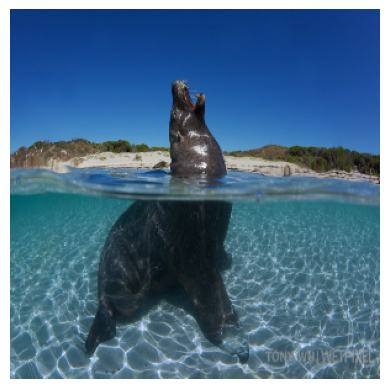

sea_lions


In [16]:
for steps, timings, counters, img, label in dataset_train.take(1):
    print(steps[0], timings[0], counters[0])
    print(img[0].shape)
    plt.imshow(img[0])
    plt.axis("off")
    plt.show()
    print(index_to_label[label[0].numpy()])

In [17]:
base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(300, 300, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation="relu"))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation="relu"))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation="softmax"))

wild_model = tf.keras.Model(
    inputs=base_model.input, outputs=top_model(base_model.output)
)

In [18]:
wild_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 300, 300, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 300, 300, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 150, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 150, 150, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 150, 150, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 75, 75, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 37, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 37, 37, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 18, 18, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 10)             │   174,078,986 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 188,793,674 (720.19 MB)

 Trainable params: 174,078,986 (664.06 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [19]:
# save the initialization of weights
wild_model.save_weights("wild_model.weights.h5")

In [20]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name="train_accuracy"
)

test_loss = tf.keras.metrics.Mean(name="test_loss")
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name="test_accuracy"
)

In [21]:
@tf.function
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = wild_model(image, training=True)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, wild_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, wild_model.trainable_variables))

    train_loss(loss)
    train_accuracy(label, predictions)


@tf.function
def test_step(image, label):
    predictions = wild_model(image, training=False)
    loss = loss_object(label, predictions)

    test_loss(loss)
    test_accuracy(label, predictions)

In [22]:
def timelined_benchmark(dataset_train, dataset_test, EPOCHS):
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

    start_time = time.perf_counter()
    print("start time: ", start_time)
    for epoch in range(EPOCHS):
        epoch_enter = time.perf_counter()

        # Reset the metrics at the start of the next epoch
        train_loss.reset_state()
        train_accuracy.reset_state()
        test_loss.reset_state()
        test_accuracy.reset_state()

        tf.print("training:")
        for steps, times, values, image, label in tqdm(
            dataset_train, total=math.floor(len(img_path_train) / BATCH_SIZE)
        ):
            time.sleep(0.1)

            steps_acc = tf.concat(
                [
                    steps_acc,
                    tf.reshape(steps, (steps.shape[0] * steps.shape[1], 1)),
                ],
                axis=0,
            )
            times_acc = tf.concat(
                [
                    times_acc,
                    tf.reshape(times, (times.shape[0] * times.shape[1], 2)),
                ],
                axis=0,
            )
            values_acc = tf.concat(
                [
                    values_acc,
                    tf.reshape(values, (values.shape[0] * values.shape[1], 3)),
                ],
                axis=0,
            )

            # record training time
            train_enter = time.perf_counter()
            train_step(image, label)
            train_elapsed = time.perf_counter() - train_enter

            time.sleep(0.1)

            train_time = tf.concat(
                [
                    tf.fill([times.shape[0], 1], train_enter),
                    tf.fill([times.shape[0], 1], train_elapsed),
                ],
                axis=1,
            )  # shape=(times.shape[0], 2)
            steps_acc = tf.concat(
                [steps_acc, tf.fill([steps.shape[0], 1], "Train")], axis=0
            )
            times_acc = tf.concat([times_acc, train_time], axis=0)
            try:
                values_acc = tf.concat([values_acc, values[:, -1, :]], axis=0)
            except Exception as e:
                print(f"Error: {e}")
                print(f"values_acc.shape: {values_acc.shape}")
                print(f"values.shape: {values.shape}")
                print(f"values[:, -1, :].shape: {values[:, -1, :].shape}")

        tf.print("testing:")
        for steps, times, values, image, label in tqdm(
            dataset_test, total=math.floor(len(img_path_test) / BATCH_SIZE)
        ):
            time.sleep(0.1)

            steps_acc = tf.concat(
                [
                    steps_acc,
                    tf.reshape(steps, (steps.shape[0] * steps.shape[1], 1)),
                ],
                axis=0,
            )
            times_acc = tf.concat(
                [
                    times_acc,
                    tf.reshape(times, (times.shape[0] * times.shape[1], 2)),
                ],
                axis=0,
            )
            values_acc = tf.concat(
                [
                    values_acc,
                    tf.reshape(values, (values.shape[0] * values.shape[1], 3)),
                ],
                axis=0,
            )

            test_enter = time.perf_counter()
            test_step(image, label)
            test_elapsed = time.perf_counter() - test_enter

            time.sleep(0.1)

            test_time = tf.concat(
                [
                    tf.fill([times.shape[0], 1], test_enter),
                    tf.fill([times.shape[0], 1], test_elapsed),
                ],
                axis=1,
            )  # shape=(times.shape[0], 2)
            steps_acc = tf.concat(
                [steps_acc, tf.fill([steps.shape[0], 1], "Test")], axis=0
            )
            times_acc = tf.concat([times_acc, test_time], axis=0)
            values_acc = tf.concat([values_acc, values[:, -1, :]], axis=0)

        template = "Epoch {:0}, Loss: {:.4f}, Accuracy: {:.4f}, test Loss: {:.4f}, test Accuracy: {:.4f}"
        tf.print(
            template.format(
                epoch + 1,
                train_loss.result(),
                train_accuracy.result() * 100,
                test_loss.result(),
                test_accuracy.result() * 100,
            )
        )

        epoch_elapsed = time.perf_counter() - epoch_enter
        steps_acc = tf.concat([steps_acc, [["Epoch"]]], axis=0)
        times_acc = tf.concat(
            [times_acc, [(epoch_enter, epoch_elapsed)]], axis=0
        )
        values_acc = tf.concat([values_acc, [[-1, epoch, -1]]], axis=0)

    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

In [24]:
timeline_Naive = timelined_benchmark(dataset_train, dataset_test, EPOCHS=3)

start time:  7616188.103002997
training:


  0%|          | 0/89 [00:00<?, ?it/s]

W0000 00:00:1730294246.695070 1400380 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730294246.797544 1400380 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730294246.801178 1400380 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730294246.804915 1400380 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730294246.809255 1400380 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730294246.813490 1400380 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730294246.819405 1400380 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730294246.836664 1400380 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730294246.842990 1400380 gp

testing:



100%|██████████| 22/22 [00:36<00:00,  1.67s/it]

Epoch 1, Loss: 4.7091, Accuracy: 25.2458, test Loss: 1.3561, test Accuracy: 64.1335
training:



100%|██████████| 89/89 [02:18<00:00,  1.56s/it]

testing:



100%|██████████| 22/22 [00:36<00:00,  1.66s/it]

Epoch 2, Loss: 1.1487, Accuracy: 59.6910, test Loss: 0.7280, test Accuracy: 77.3438
training:



100%|██████████| 89/89 [02:19<00:00,  1.57s/it]

testing:



100%|██████████| 22/22 [00:35<00:00,  1.63s/it]

Epoch 3, Loss: 0.8151, Accuracy: 72.2612, test Loss: 0.5964, test Accuracy: 82.5994
Execution time: 539.7018784843385


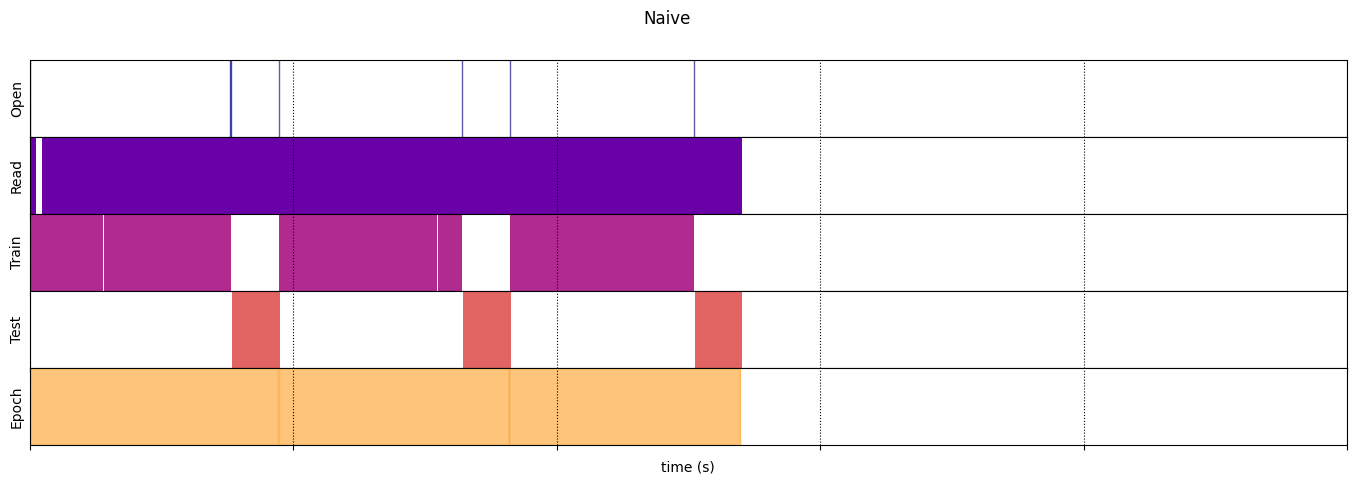

In [35]:
draw_timeline(timeline=timeline_Naive, title="Naive", min_width=1000)

In [26]:
## TODO: build `dataset_train_augmentation` and `dataset_test_augmentation` with transformation
## Remember to define your own map functions with map_decorator before calling map

# dataset_train_augmentation = tf.data.Dataset.range(1). ...
# dataset_test_augmentation = tf.data.Dataset.range(1). ...


def map_decorator(func):
    def wrapper(steps, times, values, image, label):
        # Use a tf.py_function to prevent auto-graph from compiling the method
        return tf.py_function(
            func,
            inp=(steps, times, values, image, label),
            Tout=(
                steps.dtype,
                times.dtype,
                values.dtype,
                image.dtype,
                label.dtype,
            ),
        )

    return wrapper


@map_decorator
def map_fun_with_time(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.1)

    # record the enter time into map_fun()
    map_enter = time.perf_counter()

    # image = tf.reshape(image, [IMAGE_DEPTH, IMAGE_HEIGHT, IMAGE_WIDTH])
    # image = tf.divide(
    #     tf.cast(tf.transpose(image, [1, 2, 0]), tf.float32), 255.0
    # )
    # # label = tf.one_hot(label, 10)
    # distorted_image = tf.image.random_crop(
    #     image, [IMAGE_SIZE_CROPPED, IMAGE_SIZE_CROPPED, IMAGE_DEPTH]
    # )
    # distorted_image = tf.image.resize(
    #     image, [IMAGE_SIZE_CROPPED, IMAGE_SIZE_CROPPED]
    # )
    # # distorted_image = image
    # distorted_image = tf.image.random_flip_left_right(distorted_image)
    # distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    # distorted_image = tf.image.random_contrast(
    #     distorted_image, lower=0.2, upper=1.8
    # )
    # distorted_image = tf.image.per_image_standardization(distorted_image)

    distorted_image = tf.image.random_flip_left_right(image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.per_image_standardization(distorted_image)

    map_elapsed = time.perf_counter() - map_enter
    # ----------------

    return (
        tf.concat((steps, [["Map"]]), axis=0),
        tf.concat((times, [[map_enter, map_elapsed]]), axis=0),
        tf.concat((values, [values[-1]]), axis=0),
        distorted_image,
        label,
    )


@map_decorator
def map_fun_test_with_time(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.1)

    # record the enter time into map_fun_test()
    map_enter = time.perf_counter()

    # image = tf.reshape(image, [IMAGE_DEPTH, IMAGE_HEIGHT, IMAGE_WIDTH])
    # image = tf.divide(
    #     tf.cast(tf.transpose(image, [1, 2, 0]), tf.float32), 255.0
    # )
    # label = tf.one_hot(label, 10)
    # distorted_image = tf.image.resize(
    #     image, [IMAGE_SIZE_CROPPED, IMAGE_SIZE_CROPPED]
    # )
    # # distorted_image = image
    # distorted_image = tf.image.per_image_standardization(distorted_image)

    distorted_image = tf.image.per_image_standardization(image)

    map_elapsed = time.perf_counter() - map_enter
    # ----------------

    return (
        tf.concat((steps, [["Map"]]), axis=0),
        tf.concat((times, [[map_enter, map_elapsed]]), axis=0),
        tf.concat((values, [values[-1]]), axis=0),
        distorted_image,
        label,
    )

In [27]:
dataset_train_augmentation = (
    tf.data.Dataset.range(1)
    .flat_map(dataset_generator_fun_train)
    .map(map_fun_with_time)
    .shuffle(10000)
    .batch(BATCH_SIZE, drop_remainder=True)
)
dataset_test_augmentation = (
    tf.data.Dataset.range(1)
    .flat_map(dataset_generator_fun_test)
    .map(map_fun_test_with_time)
    .batch(BATCH_SIZE, drop_remainder=True)
)

In [28]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights("wild_model.weights.h5")
timeline_Augmentation = timelined_benchmark(
    dataset_train_augmentation, dataset_test_augmentation, EPOCHS=3
)

start time:  7616732.651622006
training:


100%|██████████| 89/89 [14:00<00:00,  9.44s/it]   

testing:



100%|██████████| 22/22 [03:22<00:00,  9.20s/it]

Epoch 1, Loss: 5.7474, Accuracy: 52.0014, test Loss: 0.4347, test Accuracy: 86.1506
training:



100%|██████████| 89/89 [14:03<00:00,  9.48s/it]   

testing:



100%|██████████| 22/22 [03:23<00:00,  9.25s/it]

Epoch 2, Loss: 0.5016, Accuracy: 83.7956, test Loss: 0.3190, test Accuracy: 89.6307
training:



100%|██████████| 89/89 [13:57<00:00,  9.42s/it]   

testing:



100%|██████████| 22/22 [03:22<00:00,  9.21s/it]

Epoch 3, Loss: 0.3233, Accuracy: 89.6419, test Loss: 0.2338, test Accuracy: 93.3239
Execution time: 3130.6089690793306


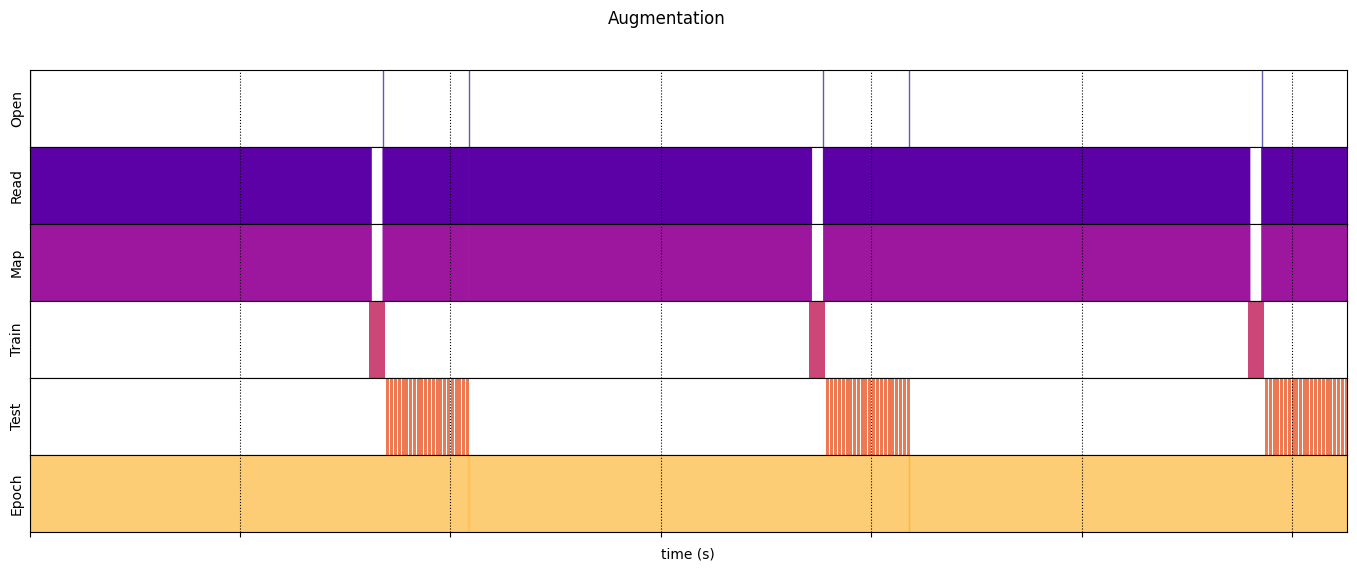

In [29]:
draw_timeline(
    timeline=timeline_Augmentation, title="Augmentation", min_width=3000
)

In [30]:
## TODO: build `dataset_train_optimized` and `dataset_test_optimized` with transformation and optimzation
## Remember to re-define your own map functions again to make mapping time re-calculated

# dataset_train_optimized = tf.data.Dataset.range(1). ...
# dataset_test_optimized = tf.data.Dataset.range(1). ...

dataset_train_optimized = (
    tf.data.Dataset.range(1)
    .interleave(
        dataset_generator_fun_train,
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    .map(map_fun_with_time, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(10000)
    .batch(BATCH_SIZE, drop_remainder=True)
    .cache()
    .prefetch(tf.data.experimental.AUTOTUNE)
)

dataset_test_optimized = (
    tf.data.Dataset.range(1)
    .interleave(
        dataset_generator_fun_test,
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    .map(
        map_fun_test_with_time,
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    .batch(BATCH_SIZE, drop_remainder=True)
    .cache()
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [31]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights("wild_model.weights.h5")
timeline_Optimized = timelined_benchmark(
    dataset_train_optimized, dataset_test_optimized, EPOCHS=3
)

start time:  7619868.533904226
training:


100%|██████████| 89/89 [02:57<00:00,  1.99s/it]  

testing:



100%|██████████| 22/22 [00:39<00:00,  1.80s/it]

Epoch 1, Loss: 6.8828, Accuracy: 48.7886, test Loss: 0.5477, test Accuracy: 83.6648


training:


100%|██████████| 89/89 [00:33<00:00,  2.65it/s]

testing:



100%|██████████| 22/22 [00:06<00:00,  3.49it/s]

Epoch 2, Loss: 0.5440, Accuracy: 82.6721, test Loss: 0.2995, test Accuracy: 90.6250
training:



100%|██████████| 89/89 [00:31<00:00,  2.87it/s]

testing:



100%|██████████| 22/22 [00:06<00:00,  3.46it/s]

Epoch 3, Loss: 0.3085, Accuracy: 89.7296, test Loss: 0.2338, test Accuracy: 92.7557
Execution time: 294.18746975716203


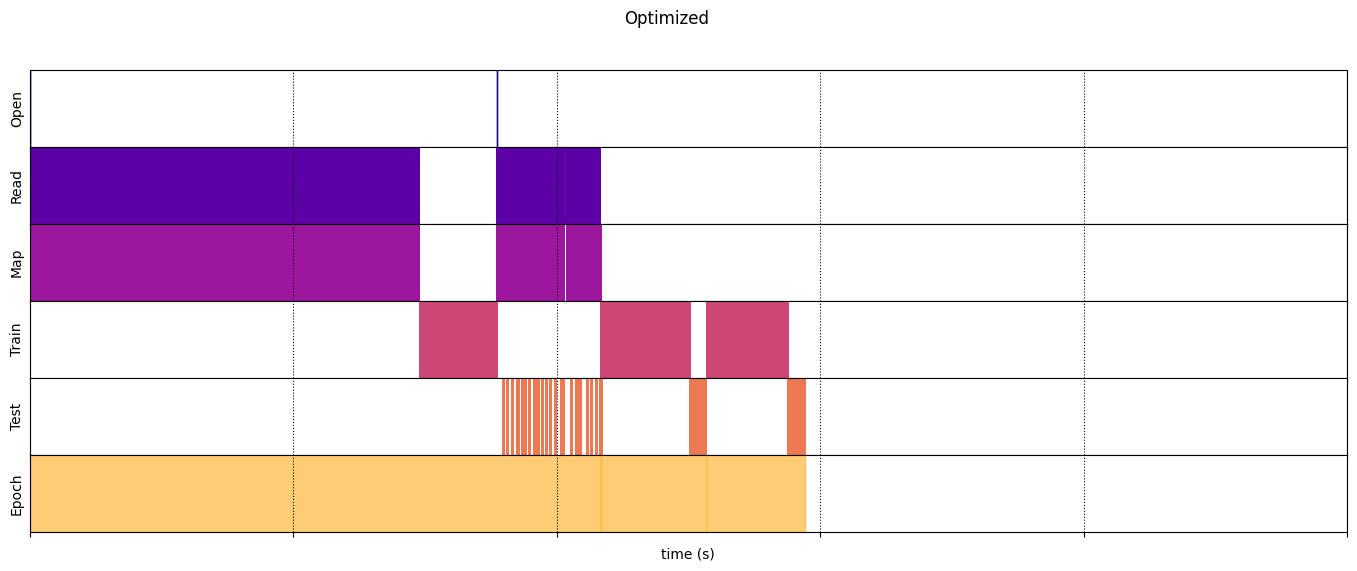

In [34]:
draw_timeline(timeline=timeline_Optimized, title="Optimized", min_width=500)

## Report

Naive version

* Execution time: 539.7018784843385 seconds
* Test accuracy: 82.5994%

Transform version

* Execution time: 3130.6089690793306 seconds
* Test accuracy: 93.3239%
* Transformation: flip left and right, brightness, standarization

Optimization version

* Execution time: 294.18746975716203 seconds
* Test accuracy: 92.7557%
* Optimizations: autotune parallel, cache, prefetch

## Description

I made sleep time 0.1 seconds because of the random error appearing. However, the error still appears until I changed the machine. After changing the machine, the error disappeared.

## Questions

* Is it possible that the more difficult training data after input transfromation may need more epochs to train to get better performance?
  * Yes, I guess. If the transformation is too complicated in the wrong way, the model may need more epochs to learn the features of the data.
  * However, if the transformation is in the right way, the model may need fewer epochs to learn the features of the data.
* Which step is the bottleneck on your device? Why? Any other steps cost more time than your expect?
  * The mapping phase. Since I make the sleep time 0.1 seconds, the mapping phase is the bottleneck.
* Speedup with optimization
  * The speedup is 10 times faster than the augment only version, with parallel that ignores the sleep time. Caching makes only the first epoch requires time and the rest of the epochs are nearly instant.
